Research Paper: https://arxiv.org/abs/1910.10699

2019 paper and revised in 2022

Code Link: https://github.com/lenscloth/RKD


In [1]:
import os
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn


In [2]:
torch.cuda.empty_cache()


In [3]:
# Configurations
# BATCH_SIZE = 128
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 10

# Transforms for CIFAR10
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Models (Using ResNet-50 as an example)
student = resnet50(pretrained=False).cuda()
teacher = resnet50(pretrained=True).cuda()  # Assuming teacher is a pretrained ResNet


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Criterion
class RkdDistance(nn.Module):
    def forward(self, student, teacher):
        student_pairwise_dist = torch.norm(student[:, :, None] - student[:, None, :], dim=0)
        teacher_pairwise_dist = torch.norm(teacher[:, :, None] - teacher[:, None, :], dim=0)
        loss = F.mse_loss(student_pairwise_dist, teacher_pairwise_dist)
        return loss

criterion = RkdDistance()
optimizer = torch.optim.Adam(student.parameters(), lr=LR)


In [5]:
# Training Loop
train_losses = []
accuracies = []

for epoch in range(EPOCHS):
    student.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        student_outputs = student(inputs)
        teacher_outputs = teacher(inputs).detach()
        loss = criterion(student_outputs, teacher_outputs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Record statistics or print them
    train_losses.append(epoch_loss / len(trainloader))
    accuracies.append(100. * correct / total)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {train_losses[-1]:.4f} Accuracy: {accuracies[-1]:.2f}")


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


Epoch [1/10] Loss: 9.5443 Accuracy: 0.04


100%|██████████| 1563/1563 [04:20<00:00,  6.00it/s]


Epoch [2/10] Loss: 5.4042 Accuracy: 0.37


100%|██████████| 1563/1563 [04:20<00:00,  6.00it/s]


Epoch [3/10] Loss: 4.5640 Accuracy: 0.22


100%|██████████| 1563/1563 [04:20<00:00,  5.99it/s]


Epoch [4/10] Loss: 4.1876 Accuracy: 0.38


100%|██████████| 1563/1563 [04:20<00:00,  6.00it/s]


Epoch [5/10] Loss: 4.0025 Accuracy: 0.67


100%|██████████| 1563/1563 [04:20<00:00,  6.00it/s]


Epoch [6/10] Loss: 3.8444 Accuracy: 0.31


100%|██████████| 1563/1563 [04:21<00:00,  5.98it/s]


Epoch [7/10] Loss: 3.6806 Accuracy: 0.16


100%|██████████| 1563/1563 [04:20<00:00,  6.00it/s]


Epoch [8/10] Loss: 3.5767 Accuracy: 0.04


100%|██████████| 1563/1563 [04:21<00:00,  5.98it/s]


Epoch [9/10] Loss: 3.4987 Accuracy: 0.10


100%|██████████| 1563/1563 [04:20<00:00,  5.99it/s]

Epoch [10/10] Loss: 3.4318 Accuracy: 0.06


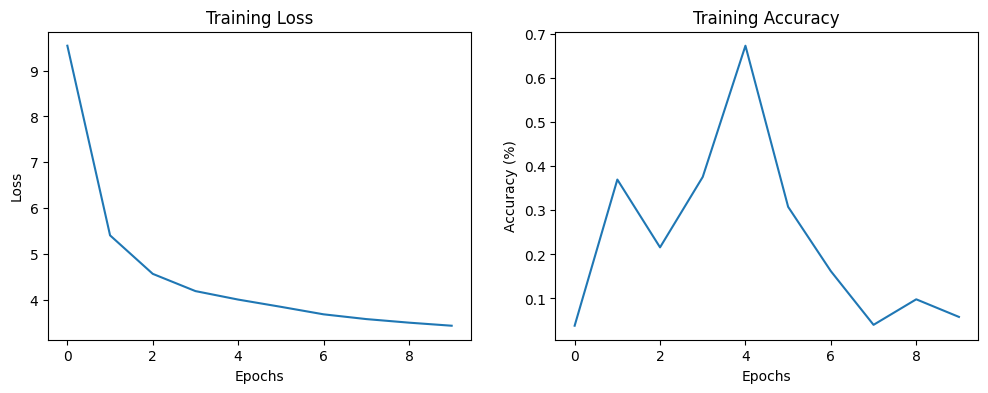

In [6]:

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.show()
